In [1]:
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances.csv

--2022-07-30 13:10:59--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4255300 (4.1M) [text/plain]
Saving to: ‘train_stances.csv’

train_stances.csv   100%[===================>]   4.06M  --.-KB/s    in 0.02s   

2022-07-30 13:11:00 (264 MB/s) - ‘train_stances.csv’ saved [4255300/4255300]

--2022-07-30 13:11:00--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375230

In [2]:
#Install neattext for datacleaning
!pip install neattext



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 8.0 MB/s 


In [3]:
#Dependencies
import pandas as pd
import os
from nltk import word_tokenize
import numpy as np
from pandas.core.frame import DataFrame
import torch
from collections import namedtuple
from torch.utils.data import Dataset, DataLoader
import neattext.functions as nfx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print(torch.cuda.is_available())

True


In [5]:
train_stances_path = os.path.join("train_stances.csv")
train_bodies_path = os.path.join("train_bodies.csv")
train_stances = pd.read_csv(train_stances_path)
train_bodies = pd.read_csv(train_bodies_path)
train_stances['Stance']

test_stances_path = os.path.join("competition_test_stances.csv")
test_bodies_path = os.path.join("competition_test_bodies.csv")
test_stances = pd.read_csv(test_stances_path)
test_bodies = pd.read_csv(test_bodies_path)
test_stances['Stance']

0        unrelated
1        unrelated
2        unrelated
3        unrelated
4        unrelated
           ...    
25408        agree
25409      discuss
25410     disagree
25411     disagree
25412        agree
Name: Stance, Length: 25413, dtype: object

In [6]:
def plot_stance_value_counts(data, column='Stance'):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=column, data=data)
    # ax.bar_label(ax.containers[0])
    plt.title("Value counts for Stances")
    plt.show()

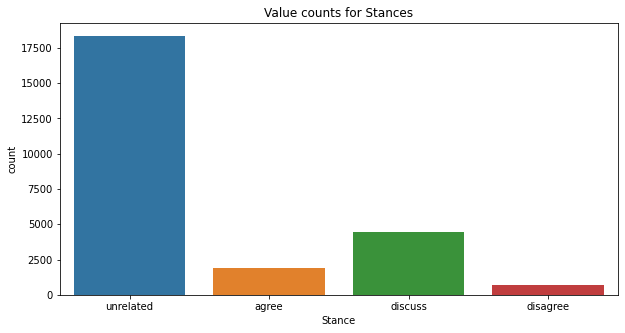

In [7]:
plot_stance_value_counts(test_stances)

In [ ]:
# test_bodies.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [ ]:
# selected_features = ['Headline','articleBody','Stance']
# train_data = train_stances.join(train_bodies.set_index("Body ID"), on="Body ID")
# test_data = test_stances.join(test_bodies.set_index("Body ID"), on="Body ID")
# train = train_data.loc[:, train_data.columns.isin(selected_features)]


In [ ]:
# train.head()

,Headline,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [8]:
#Dataset
STOP_TOKEN = '</s>'
START_TOKEN = '<s>'
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'

class FakeDataset(Dataset):
    def __init__(self, data, word2idx, tokenizer,headline_max_length,body_max_length):
        self.articles = data
        self.w2i = word2idx
        self.tokenizer = tokenizer
        self.max_len_h = headline_max_length
        self.max_len_b = body_max_length

    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        headline_ids = []
        body_ids = []
        stances_ids = []
        stances_list = ['agree','disagree','discuss','unrelated']
          

        headline = self.articles[idx].Headline
        body = self.articles[idx].articleBody
        stance = self.articles[idx].Stance

        headline_words = self.tokenizer(headline)
        body_words = self.tokenizer(body)
        for i in headline_words:
            try:
                idx = self.w2i[i]
            except KeyError:
                idx = self.w2i[UNK_TOKEN]
            headline_ids.append(idx)
        for j in body_words:
            try:
                idx = self.w2i[j]
            except KeyError:
                idx = self.w2i[UNK_TOKEN]
            body_ids.append(idx)

        # stance_list_int = [stances_list.index(stance_i) if stance_i == stance else 0 for stance_i in stances_list]
        # stances_ids.append(stance_list_int)

        stance_list_int = [1 if stance_i == stance else 0 for stance_i in stances_list]
        stances_ids.append(stance_list_int)
  
        headline_length = len(headline_ids)
        body_length = len(body_ids)
        if headline_length < self.max_len_h:
            headline_ids = headline_ids + [self.w2i[STOP_TOKEN]] + [self.w2i[PAD_TOKEN]] * (self.max_len_h - headline_length - 1)
            assert len(headline_ids) == self.max_len_h
            headline_length += 1
        else:
            headline_ids = headline_ids[:self.max_len_h-1] + [self.w2i[STOP_TOKEN]]
            headline_length = self.max_len_h
            
        if body_length < self.max_len_b-1:
            body_ids = [self.w2i[START_TOKEN]] + body_ids + [self.w2i[STOP_TOKEN]] +\
            [self.w2i[PAD_TOKEN]] * (self.max_len_b - body_length - 2)
            assert len(body_ids) == self.max_len_b
            body_length += 2
        else:
            body_ids = [self.w2i[START_TOKEN]] + body_ids[:self.max_len_b-2] + [self.w2i[STOP_TOKEN]]
            body_length = self.max_len_b
            
        headline_mask = np.zeros(self.max_len_h)
        body_mask = np.zeros(self.max_len_b)
        headline_mask[:headline_length] = 1
        body_mask[:body_length] = 1

        return torch.LongTensor(headline_ids), torch.LongTensor(body_ids), torch.LongTensor([headline_length]), \
        torch.LongTensor([body_length]),  torch.BoolTensor(headline_mask), torch.BoolTensor(body_mask), torch.LongTensor(stances_ids)

In [9]:

#Utils
selected_features = ['Headline','articleBody','Stance']
Article = namedtuple('Article', selected_features)

def data_cleaning(df,columns):
  for column in columns:

    df[column] = df[column].apply(nfx.remove_stopwords)
    df[column] = df[column].apply(nfx.remove_userhandles)
    df[column] = df[column].apply(nfx.remove_punctuations)
    df[column] = df[column].apply(nfx.remove_emojis)
    df[column] = df[column].apply(nfx.remove_emails)
    df[column] = df[column].apply(nfx.remove_urls)
  return df

def build_vocabulary(body,headline):
  body_list = body.split()
  headline_list = headline.split()
  combined_list = body_list+headline_list
  return set(combined_list)

def read_corpus(data_path_stance,data_path_body):
    '''
    param: 
    data_path_stance: str --- path to the data file containing stance and headline
    data_path_body: str --- path to the data file containing body

    return: 
    headline: list[str] --- contains the text in headline; 
    articleBody: list[str] --- contains the text in articleBody; 
    vocab: set(str) --- contains all the words appearing in the data file;
    stance: list[str] --- contains list of stance;

    '''
   
    stancesDf = pd.read_csv(data_path_stance)
    bodiesDf = pd.read_csv(data_path_body)    
    headline, articleBody, stance = [], [], []
    vocab = set()

    
    dataframe = stancesDf.join(bodiesDf.set_index("Body ID"), on="Body ID")
   
    dataframe = dataframe.loc[:, dataframe.columns.isin(selected_features)]
    dataframe = data_cleaning(dataframe,selected_features)
  
    headline = [x for x in dataframe['Headline']]
    articleBody = [x for x in dataframe['articleBody']]
    stance = [x for x in dataframe['Stance']]
    for x,y in zip(dataframe['Headline'],dataframe['articleBody']):
      temp_set =  build_vocabulary(x,y)
      vocab = vocab | temp_set

  






    return headline, articleBody, stance, vocab

def data_matching(headlines, articleBodies,stances):
    data = []
    for h,b,s in zip(headlines, articleBodies,stances):
        data.append(Article(Headline=h, articleBody=b,Stance=s))
    return data

def build_w2i(vocab):

    w2i = {}
    for i, w in enumerate(vocab):
        w2i[w] = i
    w2i[START_TOKEN] = len(w2i)
    w2i[STOP_TOKEN] = len(w2i)
    w2i[UNK_TOKEN] = len(w2i)
    w2i[PAD_TOKEN] = len(w2i)

    return w2i 

def build_i2w(w2i):
    i2w = {}
    for k,v in w2i.items():
        i2w[v] = k    
    return i2w

In [ ]:
#sample size =840
def sample_dataset(data_path_stance,data_path_body,sample_size):
    stancesDf = pd.read_csv(data_path_stance)
    bodiesDf = pd.read_csv(data_path_body)    
    headline, articleBody, stance = [], [], []
    vocab = set()

    
    dataframe = stancesDf.join(bodiesDf.set_index("Body ID"), on="Body ID")
   
    dataframe = dataframe.loc[:, dataframe.columns.isin(selected_features)]
    df_agree = dataframe.loc[dataframe['Stance']=='agree']
    df_disagree = dataframe.loc[dataframe['Stance']=='disagree']
    df_discuss = dataframe.loc[dataframe['Stance']=='discuss']
    df_unrelated = dataframe.loc[dataframe['Stance']=='unrelated']
    # df_a = df_agree.sample(n = sample_size)
    # df_da = df_disagree.sample(n = sample_size)
    # df_dc = df_discuss.sample(n = sample_size)
    df_ur = df_unrelated.sample(n = 9000)
    # df = pd.concat([df_a,df_da,df_dc,df_ur],ignore_index = True)
    df = pd.concat([df_agree,df_disagree,df_discuss,df_ur],ignore_index = True)
    
   

    df = data_cleaning(df,selected_features)
  
    headline = [x for x in df['Headline']]
    articleBody = [x for x in df['articleBody']]
    stance = [x for x in df['Stance']]
    for x,y in zip(df['Headline'],df['articleBody']):
      temp_set =  build_vocabulary(x,y)
      vocab = vocab | temp_set

  






    return headline, articleBody, stance, vocab



In [10]:
headline, articleBody, stance, vocab = read_corpus(r'train_bodies.csv',r'train_stances.csv')
test_headline, test_articleBody, test_stance, test_vocab = read_corpus(r'competition_test_bodies.csv',r'competition_test_stances.csv')
# test_src, test_tgt, _, _ = read_corpus(r'data/part2/test')

train_data = data_matching(headline,articleBody,stance)
# test_sent_pairs = lang_pairs(test_src,test_tgt)
test_data = data_matching(test_headline, test_articleBody, test_stance)

w2i = build_w2i(vocab)
i2w = build_i2w(w2i)

In [ ]:
print(len(vocab), len(headline), len(articleBody))
print(len(w2i), len(i2w))

37044 49972 49972
37048 37048


In [11]:
tokenizer = lambda x: x.split()
max_length_headline = 40
max_length_body = 110
batchsize = 32
train_dataset = FakeDataset(train_data,w2i,tokenizer,max_length_headline,max_length_body)
test_dataset = FakeDataset(test_data,w2i,tokenizer,max_length_headline,max_length_body)



train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batchsize,shuffle=False)

device = 'cuda:0' if torch.cuda.is_available else 'cpu'

In [ ]:
print(torch.cuda.is_available())

True


In [84]:
class FakeModel2(nn.Module):
  def __init__(self,embedding_size,vocab_size,hidden_size,kernel_size,num_classes):
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embedding_size
    self.hidden_size = hidden_size
    self.kernel_size = kernel_size
    self.num_classes = num_classes

    self.embed = nn.Embedding(self.vocab_size,self.embed_size)
    # self.embed_body = nn.Embedding(self.vocab_size,self.embed_size)

    self.dropout = nn.Dropout(0.5)
    self.conv1D_1 = nn.Conv1d(self.embed_size,self.hidden_size,self.kernel_size,padding = 3)
    self.conv1D_2 = nn.Conv1d(self.hidden_size,self.hidden_size,self.kernel_size,padding = 3)
    self.conv1D_3 = nn.Conv1d(self.hidden_size,self.hidden_size*2,self.kernel_size, padding=3)
    self.conv1D_4 = nn.Conv1d(self.hidden_size*2,self.hidden_size*2,self.kernel_size,padding=1)
    self.conv1D_5 = nn.Conv1d(self.hidden_size*2,self.hidden_size*3,self.kernel_size,padding=1)
    self.pooling = nn.MaxPool1d(2,2)

    # self.conv1D_body_1 = nn.Conv1d(150,64,5)
    # self.conv1D_body_2 = nn.Conv1d(150,64,5)
    # self.conv1D_body_3 = nn.Conv1d(150,64,5)
    # self.conv1D_body_4 = nn.Conv1d(150,64,5)
    # self.conv1D_body_5 = nn.Conv1d(150,64,5)


    
    self.fc = nn.Linear(19200,self.hidden_size*6)
    self.fc2 = nn.Linear(self.hidden_size*6,self.hidden_size*4)
    self.fc3 = nn.Linear(self.hidden_size*4,self.hidden_size*4)
    self.fc4 = nn.Linear(self.hidden_size*4,self.num_classes)


  def forward(self,headline,body,batch_size):
    embed_headline = self.embed(headline)
    embed_body = self.embed(body)
    embed_body = embed_body.permute(0,2,1)
    embed_headline = embed_headline.permute(0,2,1)
    conv1D_headline_1 = self.dropout(F.relu(self.conv1D_1(embed_headline)))
    conv1D_headline_1_pool = self.pooling(conv1D_headline_1)
    conv1D_headline_2 = self.dropout(F.relu(self.conv1D_2(conv1D_headline_1_pool)))
    conv1D_headline_2_pool = self.pooling(conv1D_headline_2)
    conv1D_headline_3 = self.dropout(F.relu(self.conv1D_3(conv1D_headline_2_pool)))
    conv1D_headline_3_pool = self.pooling(conv1D_headline_3)
    conv1D_headline_4 = self.dropout(F.relu(self.conv1D_4(conv1D_headline_3_pool)))
    conv1D_headline_5 = self.dropout(F.relu(self.conv1D_5(conv1D_headline_4)))

    conv1D_body_1 = self.dropout(F.relu(self.conv1D_1(embed_body)))
    conv1D_body_1_pool = self.pooling(conv1D_body_1)
    conv1D_body_2 = self.dropout(F.relu(self.conv1D_2(conv1D_body_1_pool)))
    conv1D_body_2_pool = self.pooling(conv1D_body_2)
    conv1D_body_3 = self.dropout(F.relu(self.conv1D_3(conv1D_body_2_pool)))
    conv1D_body_3_pool = self.pooling(conv1D_body_3)
    conv1D_body_4 =self.dropout( F.relu(self.conv1D_4(conv1D_body_3_pool)))
    conv1D_body_5 = self.dropout(F.relu(self.conv1D_5(conv1D_body_4)))
    # features_length = conv1D_headline_5.size()[2]+conv1D_body_5.size()[2]
    combined = torch.cat((conv1D_headline_5,conv1D_body_5),dim=2)
    flattened = combined.view(batch_size,-1)

    x = self.fc(flattened)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    return F.log_softmax(x,dim=1)




   


In [92]:
embedding_size = 300
vocab_size = len(w2i)
criterion = nn.NLLLoss(reduction='mean')
hidden_size = 256
kernel_size = 3
num_classes = 4
model2 = FakeModel2(embedding_size,vocab_size,hidden_size,kernel_size,num_classes)
model2 = model2.to(device)
optimizer = optim.SGD(model2.parameters(),lr = 1e-5)
# optimizer = optim.Adam(model.parameters(),lr = 3e-3)
epoch_num = 50

In [93]:
def accuracy2(pred,target):
  idx_pred = torch.argmax(pred, dim=1)
  idx_target = torch.argmax(target,dim=1)
  correct = idx_pred==idx_target
  score = correct.sum()/len(correct)
  
  return score

In [94]:
def train2(model2, data_loader, optimizer, criterion,epoch_num):
    epoch_loss_list=[]
    acc_total_list=[]
    for epoch in range(epoch_num):
      
      epoch_loss = 0
      acc_total = 0
      model2.train()
      for batch_data in data_loader:
          optimizer.zero_grad()
          batch_data = tuple(t.to(device) for t in batch_data[:])
          headline_ids, body_ids, headline_length, body_length,  headline_mask, body_mask, stance_ids = batch_data
          
          
          batch_size = stance_ids.size()[0]
          predictions = model2(headline_ids,body_ids,batch_size)
          # predictions = predictions.type(torch.FloatTensor).cuda().squeeze(2)
          # loss = criterion(predictions, stance_ids.squeeze(1))
          stance_ids = stance_ids.squeeze(1)
          stance_idx = torch.argmax(stance_ids,dim=1)
          # print(predictions.size())
          # print(stance_idx.size())
          loss = criterion(predictions, stance_idx)
          if epoch%10==0:
            print(predictions)
            print(stance_idx)
          
          acc = accuracy2(predictions,stance_ids)
          # print(acc)
          # print(acc/stance_ids.size()[0])
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          acc_total+=acc.item()
      epoch_loss_list.append(epoch_loss)
      acc_total_list.append(acc_total)
      
      if (epoch%10==0):
        print('Epoch: {}, loss is {}'.format(epoch+1,epoch_loss))
        print('Epoch: {}, acc is {}'.format(epoch+1,acc_total/len(data_loader)))
      
    return epoch_loss_list, acc_total_list

In [95]:
loss,acc = train2(model2,train_loader,optimizer,criterion,epoch_num)

Streaming output truncated to the last 5000 lines.
        [-1.6954, -1.8130, -1.6087, -0.7915],
        [-1.6678, -1.7836, -1.5565, -0.8383]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor([3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 2, 3, 3, 3, 2, 1, 0, 3, 3, 3, 3, 3, 3,
        0, 3, 3, 3, 3, 3, 2, 2], device='cuda:0')
tensor([[-1.6582, -1.8139, -1.6013, -0.8100],
        [-1.7191, -1.8255, -1.5778, -0.7914],
        [-1.6742, -1.7633, -1.5724, -0.8358],
        [-1.6998, -1.8268, -1.6041, -0.7868],
        [-1.6865, -1.8409, -1.5941, -0.7917],
        [-1.7131, -1.8337, -1.6000, -0.7809],
        [-1.6971, -1.8038, -1.5839, -0.8053],
        [-1.6789, -1.7948, -1.6122, -0.8034],
        [-1.6859, -1.8076, -1.5989, -0.8017],
        [-1.7190, -1.8477, -1.6102, -0.7694],
        [-1.6723, -1.8007, -1.5902, -0.8139],
        [-1.6765, -1.7835, -1.5853, -0.8209],
        [-1.7080, -1.8418, -1.6071, -0.7770],
        [-1.6837, -1.8196, -1.5907, -0.8020],
        [-1.6817, -1.7615, 

KeyboardInterrupt: ignored